In [1]:
from pygod.detector import DOMINANT,AdONE,CoLA,GAAN,ANOMALOUS
from pygod.metric import eval_roc_auc
import scipy.io
from torch_geometric.data import Data
import numpy as np
import pandas as pd
import networkx as nx
import torch
import os
from typing import Tuple, List, Literal
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import sys
import pickle
import os
from utils_unsup import set_random_seeds, eval_all
import matplotlib.pyplot as plt

# os.makedirs('./saved')
# os.makedirs('./saved/models_unsup_0727')

path_model = './saved/models_unsup_0727'
path_out = 'output/unsup'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

def save_model(model,filename):
    with open(filename,'wb') as f:
        pickle.dump(model,f)

def read_model(filename):
    with open(filename,'rb') as f:
        return(pickle.load(f))
    
def clear():
    torch.cuda.empty_cache()

def load_data(
        dataname:Literal['YelpHotel','YelpRes','Amazon','YelpNYC'],
        if_split:bool=False,
        split:Tuple[float]=(0.6,0.2,0.2)
    ) -> Tuple[Data,np.ndarray]:
    dataset = scipy.io.loadmat(f'./dataset/{dataname}/{dataname}.mat')
    dataset['Network'].toarray()
    D = nx.DiGraph(dataset['Network'].toarray())
    edges = torch.tensor([[u for (u, v) in D.edges()],[v for (u,v) in D.edges()]], dtype=torch.int64)
    attr = torch.tensor(dataset['Attributes'].toarray(), dtype=torch.float)
    label = torch.tensor(dataset['Label'])
    data = Data(x=attr, edge_index=edges)

    if if_split:
        n = label.shape[0]
        train_mask, val_mask, test_mask = np.zeros(n).astype(bool), np.zeros(n).astype(bool), np.zeros(n).astype(bool)
        indexes = np.arange(n)
        np.random.shuffle(indexes)
        n_train, n_val = int(n*split[0]),int(n*split[1])
        train_mask[indexes[:n_train]] = True
        val_mask[indexes[n_train:(n_train+n_val)]] = True
        test_mask[indexes[(n_train+n_val):]] = True
        train_mask, val_mask, test_mask = torch.tensor(train_mask), torch.tensor(val_mask), torch.tensor(test_mask)
        data.train_mask, data.val_mask, data.test_mask = train_mask, val_mask, test_mask
    return data,label

data_src, label_src = load_data('YelpHotel',if_split=True)
data_tgt, label_tgt = load_data('YelpRes',if_split=False)
set_random_seeds(123,device='gpu')

## Unsupervised Model
### DOMINANT

gpu跑不了，暂时放弃

In [17]:
model_DOMINANT = DOMINANT(hid_dim=32, num_layers=2, epoch=20, gpu=1) # 因为模型过大没法用gpu，只能临时用cpu训练
model_DOMINANT.fit(data_tgt)

OutOfMemoryError: CUDA out of memory. Tried to allocate 21.24 GiB. GPU 1 has a total capacty of 23.69 GiB of which 16.27 GiB is free. Including non-PyTorch memory, this process has 7.42 GiB memory in use. Of the allocated memory 901.56 MiB is allocated by PyTorch, and 5.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [16]:
eval_roc_auc(label_tgt, model_DOMINANT.predict(data_tgt,return_score=True)[1])

OutOfMemoryError: CUDA out of memory. Tried to allocate 21.24 GiB. GPU 0 has a total capacty of 23.69 GiB of which 16.27 GiB is free. Including non-PyTorch memory, this process has 7.42 GiB memory in use. Of the allocated memory 475.10 MiB is allocated by PyTorch, and 5.84 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [39]:
# save_model(model_DOMINANT,os.path.join(path_model,'model_DOMINANT_0714_tgt.pkl'))

In [45]:
# auc_score = eval_roc_auc(label_tgt, model_DOMINANT.predict(data_tgt,return_score=True)[1])

src训练的模型在target上auc为0.4549，但直接在target训练得到的auc也是0.456

### AdONE
This detector is transductive only. Using ``predict`` with unseen data will train the detector from scratch.

也就是说这个模型即使用src训练好了在tgt上预测，也会从头在tgt上训练一遍

In [3]:
model_AdONE = AdONE(hid_dim=64,num_layers=4,gpu=0)
model_AdONE.fit(data_tgt)

AdONE(act=<function relu at 0x7ff943c57dc0>,
      backbone=<class 'torch_geometric.nn.models.basic_gnn.GIN'>,
      batch_size=5012, compile_model=False, contamination=0.1, dropout=0.0,
      epoch=100, gpu=None, hid_dim=64, lr=0.004, num_layers=4,
      num_neigh=[-1], save_emb=False, verbose=0, w1=0.2, w2=0.2, w3=0.2,
      w4=0.2, w5=0.2, weight_decay=0.0)

In [54]:
# save_model(model_AdONE,os.path.join(path_model,'model_AdONE_0714_tgt.pkl'))

In [4]:
eval_all(label_tgt,model_AdONE.label_,model_AdONE.decision_score_)

{'acc': 0.8802873104549083,
 'auc': 0.643034859302814,
 'ap': 0.19553524848506176,
 'f1': 0.20212765957446807,
 'precision': 0.15139442231075698,
 'recall': 0.304,
 'g_mean': 0.5261223278914533,
 'f1_at_50': 0.16722408026755853,
 'precision_at_50': 0.5102040816326531,
 'recall_at_50': 0.1,
 'f1_at_100': 0.22349570200573063,
 'precision_at_100': 0.3939393939393939,
 'recall_at_100': 0.156,
 'f1_at_200': 0.23608017817371935,
 'precision_at_200': 0.2663316582914573,
 'recall_at_200': 0.212,
 'f1_at_300': 0.24408014571949,
 'precision_at_300': 0.22408026755852842,
 'recall_at_300': 0.268}

In [5]:
pd.DataFrame(eval_all(label_tgt,model_AdONE.label_,model_AdONE.decision_score_),index=['AdONE']).to_csv(os.path.join(path_out,'AdONE.csv'),index=True)

### CoLA

不知道为什么模型是越训练越差的...所以会出现source上训练好的直接用在target上反而效果更好，因为模型自己是在帮倒忙 (模型初始化后预测auc就有0.5)

直接在target上训练模型

In [2]:
# model_CoLA = CoLA(hid_dim=64,num_layers=4,gpu=0,lr=0.004,epoch=100)
model_CoLA = CoLA(gpu=0)
model_CoLA.fit(data_tgt)

CoLA(act=<function relu at 0x7f4bfb9dbdc0>,
     backbone=<class 'torch_geometric.nn.models.basic_gnn.GCN'>,
     batch_size=5012, compile_model=False, contamination=0.1, dropout=0.0,
     epoch=100, gpu=None, hid_dim=64, lr=0.004, num_layers=4,
     num_neigh=[-1, -1, -1, -1], save_emb=False, verbose=0,
     weight_decay=0.0)

In [3]:
eval_all(label_tgt,model_CoLA.label_,model_CoLA.decision_score_)

{'acc': 0.8535514764565044,
 'auc': 0.17128517429651408,
 'ap': 0.03387140438700135,
 'f1': 0.023936170212765957,
 'precision': 0.017928286852589643,
 'recall': 0.036,
 'g_mean': 0.17964686064640592,
 'f1_at_50': 0.020066889632107024,
 'precision_at_50': 0.061224489795918366,
 'recall_at_50': 0.012,
 'f1_at_100': 0.02865329512893983,
 'precision_at_100': 0.050505050505050504,
 'recall_at_100': 0.02,
 'f1_at_200': 0.035634743875278395,
 'precision_at_200': 0.04020100502512563,
 'recall_at_200': 0.032,
 'f1_at_300': 0.029143897996357013,
 'precision_at_300': 0.026755852842809364,
 'recall_at_300': 0.032}

In [4]:
model_CoLA.label_.numpy().sum()

502

由于CoLA模型基于的假设是邻居节点表现类似，我们对模型embedding后的结果进行验证，看是否真正实现了

In [5]:
from torch_geometric.utils import to_scipy_sparse_matrix
ebd = model_CoLA.model.encoder(data_tgt.x.to(torch.device('cuda:0')),data_tgt.edge_index.to(torch.device('cuda:0'))).detach().cpu().numpy()
adj_matrix = to_scipy_sparse_matrix(data_tgt.edge_index, num_nodes=data_tgt.x.shape[0])
adj = adj_matrix.toarray()
np.fill_diagonal(adj,val=0)

In [6]:
from scipy.stats import zscore
import seaborn as sns

ebd_nb_mean = (adj@ebd)/adj.sum(axis=1).reshape(-1,1)
df_ebd = pd.DataFrame({
    'cosine':(ebd*ebd_nb_mean).sum(axis=1)/np.linalg.norm(ebd,axis=1,ord=2)/np.linalg.norm(ebd_nb_mean,axis=1,ord=2),
    'label':label_tgt.numpy().flatten()
    })

Text(0.5, 1.0, 'CoLA target - normal loss')

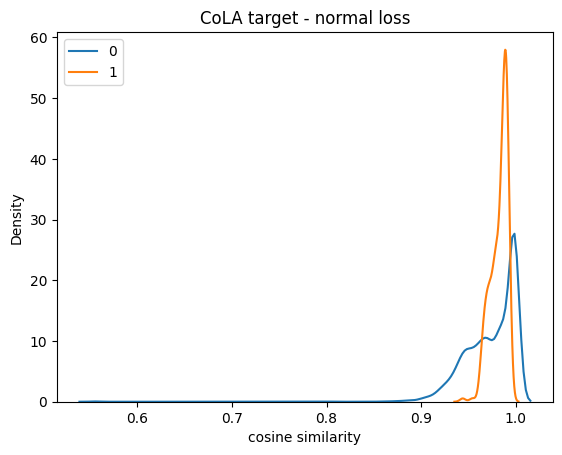

In [8]:
sns.kdeplot(data=df_ebd.loc[df_ebd.label==0,:],x='cosine')
sns.kdeplot(data=df_ebd.loc[df_ebd.label==1,:],x='cosine')
plt.legend(['0','1'])
plt.xlabel('cosine similarity')
plt.title('CoLA target - normal loss')

In [8]:
pd.DataFrame(eval_all(label_tgt,model_CoLA.decision_score_,model_CoLA.label_),index=['CoLA_tgt']).to_csv(os.path.join(path_out,'CoLA_tgt.csv'),index=True)

在source上训练

In [3]:
model_CoLA = CoLA(gpu=0)
model_CoLA.fit(data_src)

CoLA(act=<function relu at 0x7f6cb9f42dc0>,
     backbone=<class 'torch_geometric.nn.models.basic_gnn.GCN'>,
     batch_size=4322, compile_model=False, contamination=0.1, dropout=0.0,
     epoch=100, gpu=None, hid_dim=64, lr=0.004, num_layers=4,
     num_neigh=[-1, -1, -1, -1], save_emb=False, verbose=0,
     weight_decay=0.0)

In [45]:
model_CoLA.predict(data_tgt,return_score=True)[0].numpy().sum()

2881

In [52]:
(np.abs(model_CoLA.predict(data_tgt,return_score=True)[0].numpy()-label_tgt.numpy())).mean()

0.5592735455656623

In [4]:
eval_all(label_tgt,*model_CoLA.predict(data_tgt,return_score=True))

{'acc': 0.4389465283320032,
 'auc': 0.6473490130197396,
 'ap': 0.1975608487294006,
 'f1': 0.11068943706514864,
 'precision': 0.06009615384615385,
 'recall': 0.7,
 'g_mean': 0.5455905485059905,
 'f1_at_50': 0.18060200668896323,
 'precision_at_50': 0.5510204081632653,
 'recall_at_50': 0.108,
 'f1_at_100': 0.19484240687679086,
 'precision_at_100': 0.3434343434343434,
 'recall_at_100': 0.136,
 'f1_at_200': 0.21380846325167038,
 'precision_at_200': 0.24120603015075376,
 'recall_at_200': 0.192,
 'f1_at_300': 0.21857923497267762,
 'precision_at_300': 0.20066889632107024,
 'recall_at_300': 0.24}

In [5]:
pd.DataFrame(eval_all(label_tgt,*model_CoLA.predict(data_tgt,return_score=True)),index=['CoLA_src']).to_csv(os.path.join(path_out,'CoLA_src.csv'),index=True)

src训练的模型在target上auc为0.6934，但直接在target训练得到的auc最高只有0.3左右？

### GAAN

In [11]:
model_GAAN = GAAN(noise_dim=16,hid_dim=64,num_layers=4,gpu=-1)
model_GAAN.fit(data_src)

GAAN(act=<function relu at 0x7faaedda2b80>,
     backbone=<class 'torch_geometric.nn.models.basic_gnn.GIN'>,
     batch_size=4322, compile_model=False, contamination=0.1, dropout=0.0,
     epoch=100, gpu=None, hid_dim=64, lr=0.004, noise_dim=16, num_layers=1,
     num_neigh=[-1], save_emb=False, verbose=0, weight=0.5,
     weight_decay=0.0)

In [12]:
auc_score = eval_roc_auc(label_tgt, model_GAAN.predict(data_tgt,return_score=True)[1])
auc_score

0.5378983620327594

In [13]:
save_model(model_GAAN,os.path.join(path_model,'model_GAAN_0714_src.pkl'))

src训练的模型在target上auc为0.5379，在target训练的auc为0.4800

### ANOMALOUS
This detector is transductive only

这个也是因为模型本身不行，直接应用auc都不到0.5（包括在ACT那篇文章里的表现也都不到0.5）

In [6]:
model_ANOMALOUS = ANOMALOUS(gpu=3)
model_ANOMALOUS.fit(data_tgt)

ANOMALOUS(contamination=0.1, epoch=100, gamma=1.0, gpu=None, lr=0.004,
          verbose=0, weight_decay=0.0)

In [7]:
eval_all(label_tgt,model_ANOMALOUS.label_,model_ANOMALOUS.decision_score_)

{'acc': 0.852952913008779,
 'auc': 0.45820873582528343,
 'ap': 0.04224242796608321,
 'f1': 0.018641810918774968,
 'precision': 0.013972055888223553,
 'recall': 0.028,
 'g_mean': 0.15841508164703932,
 'f1_at_50': 0.006688963210702342,
 'precision_at_50': 0.02040816326530612,
 'recall_at_50': 0.004,
 'f1_at_100': 0.0057306590257879654,
 'precision_at_100': 0.010101010101010102,
 'recall_at_100': 0.004,
 'f1_at_200': 0.004454342984409799,
 'precision_at_200': 0.005025125628140704,
 'recall_at_200': 0.004,
 'f1_at_300': 0.01092896174863388,
 'precision_at_300': 0.010033444816053512,
 'recall_at_300': 0.012}

In [9]:
pd.DataFrame(eval_all(label_tgt,model_ANOMALOUS.label_,model_ANOMALOUS.decision_score_),index=['ANOMALOUS']).to_csv(os.path.join(path_out,'ANOMALOUS.csv'),index=True)

src训练的模型在target上auc为0.4913，在target训练的auc为0.4724

---

In [11]:
dflist = []
for file in os.listdir(path_out):
    if 'csv' in file:
        dflist.append(pd.read_csv(os.path.join(path_out,file),index_col=0))
pd.concat(dflist,axis=0).to_excel(os.path.join(path_out,'unsup.xlsx'))

In [31]:
os.listdir(path_out)

['CoLA_tgt.csv', 'CoLA_src.csv', 'AdONE.csv', 'ANOMALOUS.csv', 'unsup.xlsx']